In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA version: {torch.version.cuda}") if device.type == 'cuda' else None

Using device: cpu


In [3]:
import sys
sys.path.append("..")  # Add parent directory to path
from python_helpers import get_project_root_dir
from datasets import SoundTracksDataset
import models


/Users/jigneshmotwani/Moodify-CDS-2025/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
full_dataset = SoundTracksDataset()
print(f"Dataset size: {len(full_dataset)} samples")
print(f"Sample features shape: {full_dataset.melspecs[0].shape}")

Dataset size: 192 samples
Sample features shape: torch.Size([128, 323])


In [5]:
train_val, test = full_dataset.train_test_split(split_size=0.2)
train, val = train_val.train_test_split(split_size=0.25)
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 114, Val: 39, Test: 39


In [ ]:
MODEL_TYPE = 'whisper'  # Options: 'nilscnn', 'vgg', 'resnet', 'yamnet', 'evocnn', 'whisper'
FEATURE_TYPE = 'waveforms'  # Options: 'waveform', 'melspec', 'logmelspec', 'stft', 'cqt'

model = {
    'nilscnn': models.NilsHMeierCNN(FEATURE_TYPE),
    'vgg': models.VGGStyleCNN(FEATURE_TYPE),
    'resnet': models.ResNetStyleCNN(FEATURE_TYPE),
    'whisper': models.WhisperLargeV3(FEATURE_TYPE),
}[MODEL_TYPE].to(device)

print(f"Selected model: {MODEL_TYPE.upper()}")
print(model)


In [ ]:
from train import ModelTrainer

trainer = ModelTrainer(
    task='multiclass',
    num_classes=4,
    device=device
)

In [ ]:
trainer.train(
    model=model,
    train_dset=train.to(device),
    val_dset=val.to(device),
    batch_size=16,
    max_epochs=20,
    lr=0.0001,
    lambda_val=0.01,
    l1_ratio=0.0,
    take_best=True
)

Training start
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250401-010323-779738/best.pt
Epoch 0    Train Loss=8.7599    Train Acc=0.2982    Val Loss=10.3254    Val Acc=0.1795
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250401-010323-779738/best.pt
Epoch 1    Train Loss=1.8681    Train Acc=0.2982    Val Loss=2.2029    Val Acc=0.1795
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250401-010323-779738/best.pt
Epoch 2    Train Loss=1.4720    Train Acc=0.4035    Val Loss=1.7464    Val Acc=0.2051
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250401-010323-779738/best.pt
Epoch 3    Train Loss=1.2591    Train Acc=0.5088    Val Loss=1.4364    Val Acc=0.4359
Epoch 4    Train Loss=1.2207    Train Acc=0.4912    Val Loss=1.3845    Val Acc=0.4359
Successfully saved to /Users/jigneshmotwani/Moodify-CDS-2025/runs/20250401-010323-779738/best.pt
Epoch 5    Train Loss=1.1403    Train Acc=0.5877    Val Loss=1.2903  

In [ ]:
test = test.to(device)
test_loss, test_acc, test_cm = trainer.evaluate_performance(model, test)
print(f"\nFinal Test Performance:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2%}")


Final Test Performance:
Loss: 1.0056 | Accuracy: 53.85%


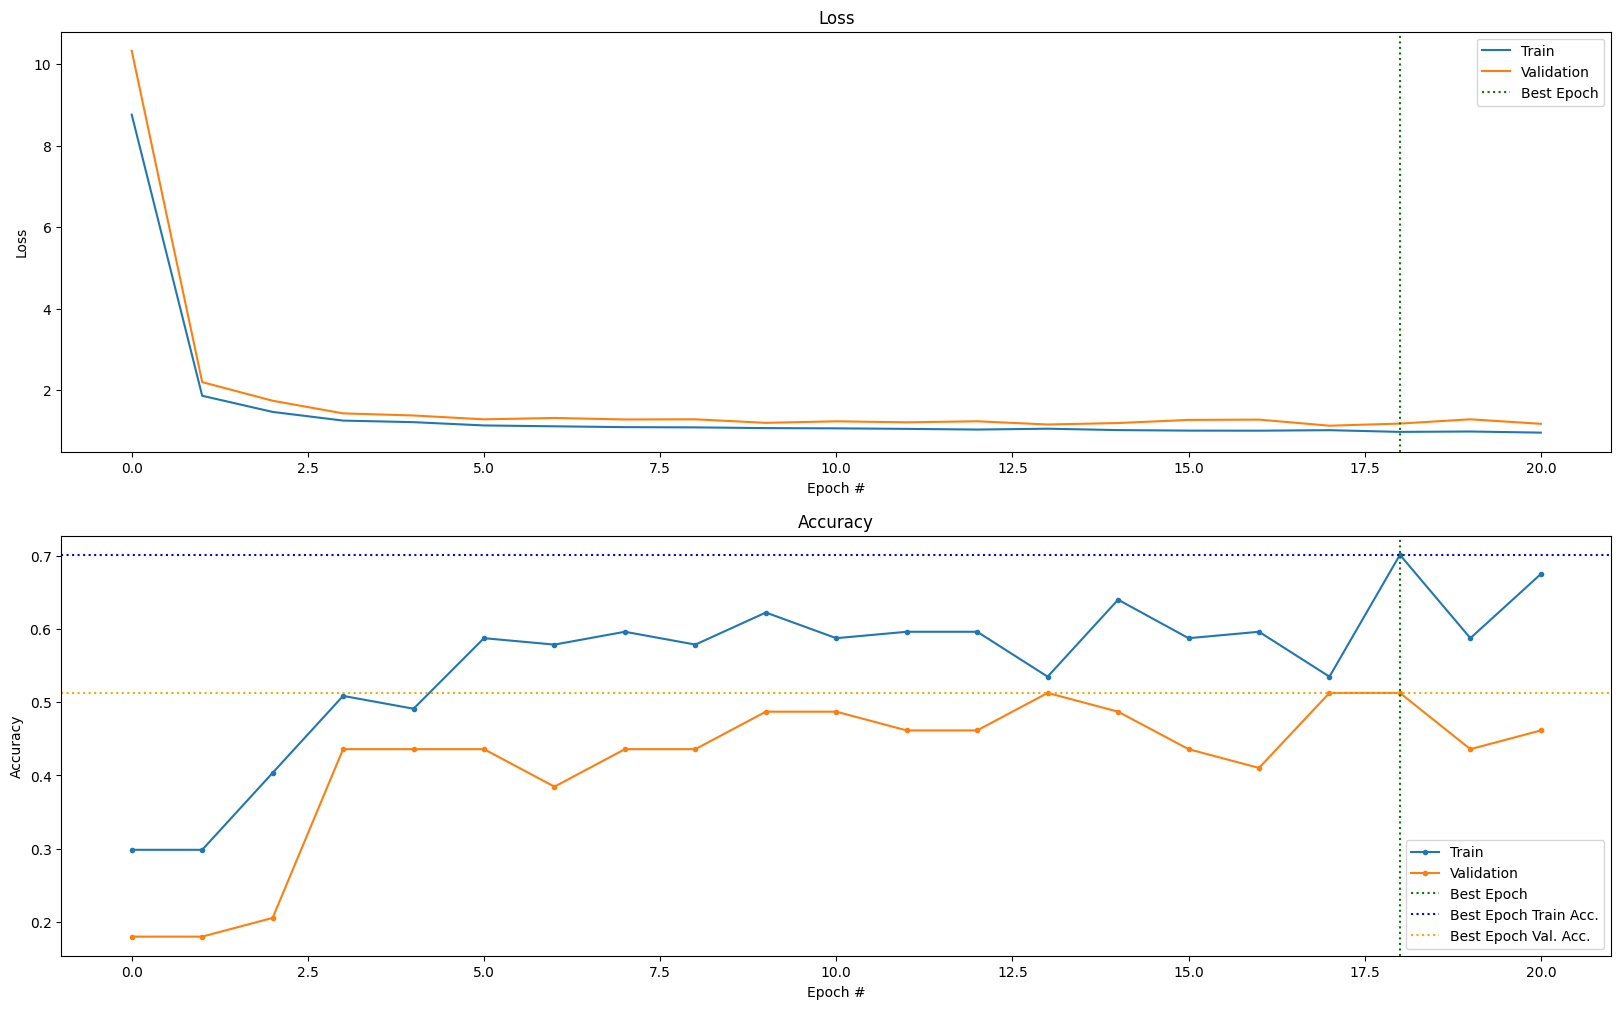

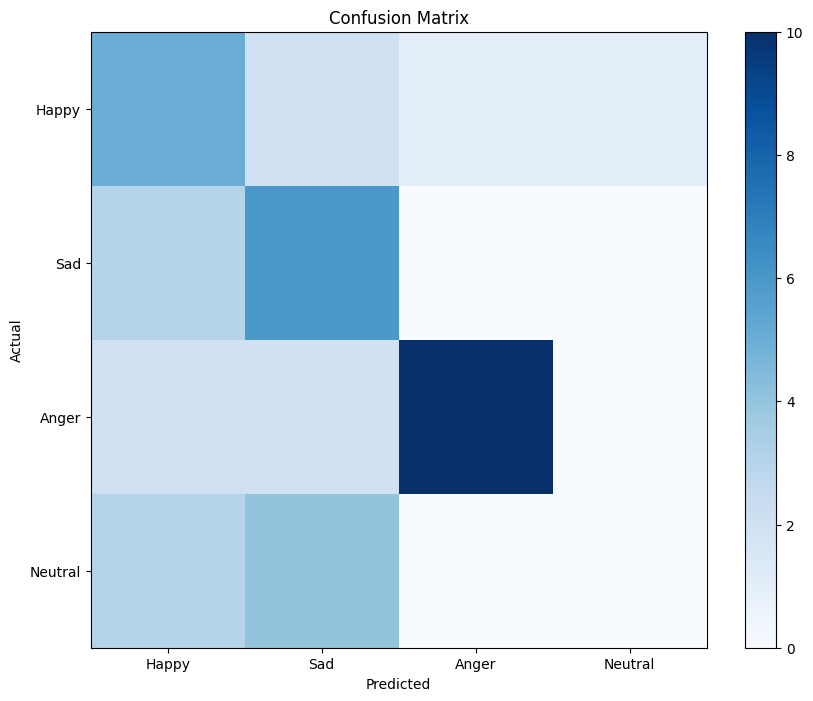

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(test_cm.cpu().numpy(), cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(4), ['Happy', 'Sad', 'Anger', 'Neutral'])
plt.yticks(range(4), ['Happy', 'Sad', 'Anger', 'Neutral'])
plt.colorbar()
plt.show()

In [ ]:
sample_idx = np.random.choice(len(test), 3)
for idx in sample_idx:
    features, true_label = test[idx]
    with torch.no_grad():
        pred = model({k:v.unsqueeze(0).to(device) for k,v in features.items()})
    
    print(f"\nSample {idx}:")
    print(f"True: {true_label.item()} | Predicted: {pred.argmax().item()}")
    display(Audio(features['waveforms'].cpu().numpy(), rate=44100))


Sample 0:
True: 2 | Predicted: 2



Sample 31:
True: 3 | Predicted: 0



Sample 25:
True: 1 | Predicted: 1
